In [1]:
## first time series test
# append ../../ to make link to main repo work
import sys
sys.path.append('../../')

# import external packages
import numpy as np
import pandas as pd
import numba
from numba import vectorize
import glob # for file search
import copy
import os # operating system stuff
import re # regex


import geopandas as gpd
import rasterio as rio
import rasterio.mask
from rasterio.plot import plotting_extent
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import pyproj
from pyproj import CRS
from inpoly import inpoly2 # for fast inpolygon checks
import utm

import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib import cm as mpl_cm
from matplotlib import colors as mcolors 
import matplotlib.image as mplimg

from mpl_toolkits.axes_grid1 import make_axes_locatable # for colorbar scaling
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

import seaborn as sns
from matplotlib import rc_file_defaults
rc_file_defaults()
# sns.set(style=None, color_codes=True)

from shapely.geometry import Polygon
from shapely.geometry.point import Point
import datetime

import configparser

from cmcrameri import cm # for scientific colourmaps

###########################
# import main local package
import SPOTSAR_main as sm


In [2]:
## Compare EDM and SPOT displacement

# steps:

# 1: Determine EDM vector
# 2: Determine SPOT vector
# 3: Determine angle between vectors
# 4: Project SPOT displacements onto EDM vector
# 5: Plot results

In [3]:
# load EDM positions

### get EDM positions
pos_bad = np.array([110.410626, -7.526175, 1276])
reflectors = np.array(
    [[110.439757, -7.537567, 2407], [110.440165, -7.537451, 2425], [110.439260, -7.537533, 2360]]
)

# load SPOT time-series data
# CSK
CSK_TS_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/CSK/dsc1/CSK_SPOT_dsc_win13_ts_inv.csv'
CSK_TS = pd.read_csv(CSK_TS_FILE)
# TSX
TSX_TS_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/TSX/staring_134/TSX_ST134_win13_ts_inv.csv'
TSX_TS = pd.read_csv(TSX_TS_FILE)


# show TS data

print(CSK_TS)

print(TSX_TS)


        Unnamed: 0   Longitude  Latitude  r_disp_  a_disp_  r_disp_20200910  \
0                0  110.483566 -7.519673      0.0      0.0        -0.081862   
1                1  110.483627 -7.519764      0.0      0.0        -0.110186   
2                2  110.483574 -7.519828      0.0      0.0        -0.116883   
3                3  110.483536 -7.519897      0.0      0.0        -0.141539   
4                4  110.483505 -7.519970      0.0      0.0        -0.152580   
...            ...         ...       ...      ...      ...              ...   
282265      310758  110.418274 -7.561081      0.0      0.0         0.012227   
282266      310761  110.427368 -7.509089      0.0      0.0        -0.021778   
282267      310764  110.418236 -7.561071      0.0      0.0         0.036422   
282268      310765  110.418282 -7.561155      0.0      0.0         0.046467   
282269      310775  110.418449 -7.560341      0.0      0.0         0.040927   

        a_disp_20200910  r_disp_20200919  a_disp_20

In [62]:
# define vectors
def deg2rad(deg):
    return (deg/360)*2*np.pi
def get_sar_vector(heading, inc):
    # we assume right looking
    flight_dir = -heading
    P_los= [np.sin(deg2rad(inc))*np.cos(deg2rad(flight_dir)),
            np.sin(deg2rad(inc))*np.sin(deg2rad(flight_dir)),
            -np.cos(deg2rad(inc))]
    
    P_azi = [np.cos(deg2rad(flight_dir+90)),
             np.sin(deg2rad(flight_dir+90)),
             0]
    return P_los, P_azi

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

    

CSK_heading = -167.9513445
CSK_inc = 35.6490

TSX_heading = 191.4694521
TSX_inc = 37.5723

CSK_los, CSK_azi = get_sar_vector(CSK_heading,CSK_inc)
TSX_los, TSX_azi = get_sar_vector(TSX_heading,TSX_inc)

# get EDM vector
pos_bad_UTM = utm.from_latlon(pos_bad[1],pos_bad[0])
RB1_UTM =  utm.from_latlon(reflectors[0,1],reflectors[0,0])
RB2_UTM =  utm.from_latlon(reflectors[1,1],reflectors[1,0])
RB3_UTM =  utm.from_latlon(reflectors[2,1],reflectors[2,0])

BAD_RB1_diff = [RB1_UTM[0]-pos_bad_UTM[0], RB1_UTM[1]-pos_bad_UTM[1],reflectors[0,2]-pos_bad[2]]
BAD_RB2_diff = [RB2_UTM[0]-pos_bad_UTM[0], RB2_UTM[1]-pos_bad_UTM[1],reflectors[1,2]-pos_bad[2]]
BAD_RB3_diff = [RB3_UTM[0]-pos_bad_UTM[0], RB3_UTM[1]-pos_bad_UTM[1],reflectors[2,2]-pos_bad[2]]

RB1_heading = np.arctan2(BAD_RB1_diff[1],BAD_RB1_diff[2])

print(BAD_RB1_diff)
print(BAD_RB2_diff)
print(BAD_RB3_diff)
# normalise vector

BAD_RB1_vec = BAD_RB1_diff / np.linalg.norm(BAD_RB1_diff)
BAD_RB2_vec = BAD_RB2_diff / np.linalg.norm(BAD_RB2_diff)
BAD_RB3_vec = BAD_RB3_diff / np.linalg.norm(BAD_RB3_diff)


RB1_heading = np.arctan2(BAD_RB1_vec[1],BAD_RB1_vec[2])
RB2_heading = np.arctan2(BAD_RB2_vec[1],BAD_RB2_vec[2])
RB3_heading = np.arctan2(BAD_RB3_vec[1],BAD_RB3_vec[2])

RB1_inc = angle_between([BAD_RB1_vec[0],BAD_RB1_vec[1],0],BAD_RB1_vec)
RB2_inc = angle_between([BAD_RB2_vec[0],BAD_RB2_vec[1],0],BAD_RB2_vec)
RB3_inc = angle_between([BAD_RB3_vec[0],BAD_RB3_vec[1],0],BAD_RB3_vec)

print(np.rad2deg(RB1_heading),np.rad2deg(RB1_inc))
print(np.rad2deg(RB2_heading),np.rad2deg(RB2_inc))
print(np.rad2deg(RB3_heading),np.rad2deg(RB3_inc))


print(BAD_RB2_vec)


# print(BAD_RB1_vec)
# print(BAD_RB2_vec)
# print(BAD_RB3_vec)

# print(CSK_los)
# print(CSK_azi)


[3215.581481641915, -1255.2107189260423, 1131.0]
[3260.5776117678033, -1242.3287064880133, 1149.0]
[3160.7451661936357, -1251.5222361590713, 1084.0]
-47.979758894659334 18.141225445081147
-47.23500368693916 18.22664847928513
-49.1026828144929 17.685931402374724
[ 0.88758292 -0.33818233  0.31277672]


In [5]:
# load EDM data

# EDM data
import datetime
dates = ['2020-04-24',0
         '2020-05-01',1
         '2020-05-08',2
         '2020-05-15',3
         '2020-05-22',4
         '2020-05-29',5
         '2020-06-05',6
         '2020-06-12',7
         '2020-06-19',8
         '2020-06-26',9
         '2020-07-03',10
         '2020-07-10',1
         '2020-07-17',2
         '2020-07-24',3
         '2020-07-31',4
         '2020-08-07',5
         '2020-08-14',6
         '2020-08-21',7
         '2020-08-28',8
         '2020-09-04',9
         '2020-09-11',20
         '2020-09-18',1
         '2020-09-25',2
         '2020-10-02',3
         '2020-10-09',4
         '2020-10-16',5
         '2020-10-23',6
         '2020-10-30',7
         '2020-11-06',8
         '2020-11-13',9
         '2020-11-20',30
         '2020-11-27',1
         '2020-12-04',2
         '2020-12-11',3
         '2020-12-18',4
         '2020-12-25',5
         '2021-01-01',6
         '2021-01-08',7
         '2021-01-15',8
         '2021-01-22',9
         '2021-01-29',40
         '2021-02-05',1
         '2021-02-12',2
         '2021-02-19',3
         '2021-02-26',4
         '2021-03-05',5
         '2021-03-12',6
         '2021-03-19',7
         '2021-03-26',8
         '2021-04-01',9
         '2021-04-09',50
         '2021-04-16',1
         '2021-04-23',2
         '2021-04-30',3
         '2021-05-07',4
         '2021-05-14',5
         '2021-05-21',6
         '2021-06-04',7
         '2021-06-11',8
         '2021-06-18',9
         '2021-06-25',60
         '2021-07-02',1
         '2021-07-09',2
         '2021-07-16',3
         '2021-07-23',4
         '2021-07-30',5
         '2021-08-05',6
         '2021-08-13',7
         '2021-08-20',8
         '2021-08-27',9
         '2021-09-03',70
         '2021-09-10',1
         '2021-09-17',2
         '2021-09-24',3
         '2021-10-01',4
         '2021-10-08',5
         '2021-10-15',6
         '2021-10-22',7
         '2021-10-29',8
         '2021-11-05',9
         '2021-11-12',80
         '2021-11-19',1
         '2021-11-26',2
         '2021-12-03',3
         '2021-12-10',4
         '2021-12-17',5
         '2021-12-24',6
         '2021-12-31']7

EDM_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates]

EDM_rate = [   0,    0,    0,    0,    0,    0,    0,    0,   -1, -2/7,
            -2/7, -2/7, -1/7,    0, -2/7, -2/7, -1/7, -1/7, -2/7, -2/7,
            -2/7, -2/7, -3/7, -2/7,   -1,   -2,   -4,   -9,  -10,   -9,
             -11,  -11,   -9,   -9,  -11,  -14,  -15,   -6, -0.8, -0.4,
               0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
               0,    0, -0.5, -0.6, -0.7,    0,   -1, -1.8, -0.7,   -2,
            -0.7,   -4,   -8,   -7,  -11,  -12, -7.7, -1.9,    0,    0,
               0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            -0.2, -0.2, -0.7, -0.5, -0.4, -0.2, -0.2, -0.4]

EDM_dist_min_max = np.array([[4044.834, 4044.840, 3859.108, 3859.115],
                             [4044.836, 4044.841, 3859.106, 3859.112],
                             [4044.830, 4044.840, 3859.102, 3859.114],
                             [4044.832, 4044.837, 3859.106, 3859.113],
                             [4044.836, 4044.842, 3859.108, 3859.114],
                             [4044.836, 4044.841, 3859.110, 3859.116],
                             [4044.834, 4044.840, 3859.110, 3859.116],
                             [4044.835, 4044.846, 3859.110, 3859.115],
                             [4044.769, 4044.841, 3859.055, 3859.122],
                             [4044.738, 4044.763, 3859.027, 3859.051],
                             [4044.719, 4044.738, 3859.011, 3859.031],
                             [4044.697, 4044.718, 3858.996, 3859.017],
                             [4044.690, 4044.701, 3858.995, 3859.003],
                             [4044.681, 4044.691, 3858.990, 3858.998],
                             [4044.659, 4044.682, 3858.976, 3858.990],
                             [4044.640, 4044.657, 3858.962, 3858.974],
                             [4044.626, 4044.641, 3858.952, 3858.963],
                             [4044.604, 4044.621, 3858.934, 3858.948],
                             [4044.580, 4044.598, 3858.925, 3858.932],
                             [4044.558, 4044.574, 3858.905, 3858.922],
                             [4044.540, 4044.556, 3858.902, 3858.908],
                             [4044.510, 4044.526, 3858.875, 3858.893],
                             [4044.466, 4044.500, 3858.849, 3858.874],
                             [4044.433, 4044.459, 3858.828, 3858.844],
                             [4044.319, 4044.338, 3858.759, 3858.772],
                             [4044.183, 4044.319, 3858.663, 3858.759],
                             [4043.795, 4044.117, 3858.347, 3858.639],
                             [4043.102, 4043.780, 3857.719, 3858.334],
                             [4042.361, 4043.057, 3856.911, 3857.681],
                             [4041.388, 4042.227, 3856.099, 3856.899],
                             [4040.604, 4041.383, 3855.342, 3856.090],
                             [4039.829, 4040.567, 3854.566, 3855.308],
                             [4039.179, 4039.801, 3853.850, 3854.537],
                             [4038.727, 4039.087, 3853.442, 3853.816],
                             [4037.761, 4038.238, 3852.457, 3852.954],
                             [4036.760, 4037.753, 3851.429, 3852.448],
                             [4035.710, 4036.748, 3850.333, 3851.419],
                             [4035.318, 4035.707, 3849.916, 3850.328],
                             [4035.243, 4035.297, 3849.843, 3850.899],
                             [4035.220, 4035.245, 3849.812, 3849.837],
                             [4035.213, 4035.218, 3849.804, 3849.811],
                             [4035.164, 4035.214, 3849.763, 3849.802],
                             [4035.158, 4035.168, 3849.748, 3849.763],
                             [4035.148, 4035.160, 3849.741, 3849.758],
                             [4035.146, 4035.156, 3849.742, 3849.753],
                             [4035.145, 4035.153, 3849.738, 3849.749],
                             [4035.131, 4035.148, 3849.729, 3849.746],
                             [4035.124, 4035.137, 3849.724, 3849.735],
                             [4035.093, 4035.124, 3849.705, 3849.725],
                             [4035.091, 4035.098, 3849.700, 3849.709],
                             [4035.083, 4035.097, 3849.695, 3849.708],
                             [4035.059, 4035.090, 3849.678, 3849.702],
                             [4035.021, 4035.058, 3849.651, 3849.681],
                             [4034.976, 4035.022, 3849.616, 3849.653],
                             [4034.910, 4034.973, 3849.557, 3849.616],
                             [4034.885, 4034.903, 3849.539, 3849.554],
                             [4034.820, 4034.887, 3849.485, 3849.542],
                             [4034.623, 4034.742, 3849.311, 3849.421],
                             [4033.827, 4033.874, 3848.518, 3848.558],
                             [4034.441, 4034.572, 3849.143, 3849.267],
                             [4034.403, 4034.452, 3849.105, 3849.154],
                             [4034.084, 4034.385, 3848.797, 3849.087],
                             [4033.528, 4034.078, 3848.231, 3848.793],
                             [4033.039, 4033.522, 3847.721, 3848.222],
                             [4032.321, 4033.033, 3846.975, 3847.716],
                             [4031.519, 4032.220, 3846.140, 3846.867],
                             [4030.990, 4031.499, 3845.602, 3846.119],
                             [4030.780, 4030.845, 3845.388, 3845.529],
                             [4030.770, 4030.785, 3845.375, 3845.390], 
                             [4030.751, 4030.772, 3845.362, 3845.377],
                             [4030.740, 4030.761, 3845.353, 3845.365],
                             [4030.723, 4030.746, 3845.338, 3845.356],
                             [4030.716, 4030.726, 3845.332, 3845.343],
                             [4030.698, 4030.698, 3845.314, 3845.322],
                             [4030.694, 4030.700, 3845.309, 3845.315],
                             [4030.681, 4030.696, 3845.299, 3845.310],
                             [4030.675, 4030.685, 3845.295, 3845.304],
                             [4030.658, 4030.676, 3845.285, 3845.296],
                             [4030.663, 4030.667, 3845.269, 3845.286],
                             [  np.nan,   np.nan, 3845.265, 3845.276],
                             [4030.632, 4030.643, 3845.243, 3845.258],
                             [4030.627, 4030.633, 3845.226, 3845.242],
                             [4030.603, 4030.618, 3845.226, 3845.242],
                             [4030.570, 4030.583, 3845.133, 3845.158],
                             [4030.537, 4030.553, 3845.097, 3845.116],
                             [4030.520, 4030.536, 3845.080, 3845.095],
                             [4030.511, 4030.526, 3845.075, 3845.085],
                             [4030.483, 4030.511, 3845.057, 3845.079]])


dates_lavadomes = ['2020-02-19',
                   '2020-06-13',
                   '2020-07-11',
                   '2020-07-26',
                   '2020-10-29',
                   '2020-11-03',
                   '2020-11-16',
                   '2021-01-04',
                   '2021-01-14',
                   '2021-01-21',  
                   '2021-01-25',
                   '2021-01-28',
                   '2021-02-04',
                   '2021-02-11',
                   '2021-02-17',
                   '2021-02-25',
                   '2021-03-05',
                   '2021-03-11',
                   '2021-03-18',
                   '2021-03-25',
                   '2021-04-01',
                   '2021-04-07',
                   '2021-04-08',
                   '2021-04-15',
                   '2021-04-21',
                   '2021-04-22',
                   '2021-04-28',
                   '2021-05-02',
                   '2021-05-16',
                   '2021-05-20',
                   '2021-05-28',
                   '2021-06-08',
                   '2021-06-17',
                   '2021-06-24',
                   '2021-07-01',
                   '2021-07-08',
                   '2021-07-15',
                   '2021-07-22',
                   '2021-07-28',
                   '2021-08-05',
                   '2021-08-19',
                   '2021-08-26',
                   '2021-09-01',
                   '2021-09-09',
                   '2021-09-16',
                   '2021-09-23',
                   '2021-09-30',
                   '2021-10-07',
                   '2021-10-14',
                   '2021-10-21',
                   '2021-10-28',
                   '2021-11-04',
                   '2021-11-11',
                   '2021-11-18',
                   '2021-11-25',
                   '2021-12-02',
                   '2021-12-09',
                   '2021-12-16',
                   '2021-12-23',
                   '2021-12-30',
]

lavadome_dates = [datetime.datetime.strptime(date,'%Y-%m-%d') for date in dates_lavadomes]


lava_dome_vol_rate =np.array([[291000, np.nan, np.nan, np.nan],
                    [200000, np.nan, np.nan, np.nan],
                    [200000, np.nan, np.nan, np.nan],
                    [200000, np.nan, np.nan, np.nan],
                    [200000, np.nan, np.nan, np.nan],
                    [200000, np.nan, np.nan, np.nan],
                    [200000, np.nan, np.nan, np.nan],
                    [200000, np.nan, 0 , np.nan],
                    [np.nan, np.nan, 46766, 8500],
                    [np.nan, np.nan, 104000,8600],
                    [np.nan, np.nan, 157000, np.nan],
                    [np.nan, np.nan, 62000, np.nan],
                    [np.nan, np.nan, 117400, 12600],
                    [np.nan, np.nan, 295000, 48900],
                    [426000,  10000, 397500, 25200],
                    [np.nan, np.nan, 618700, 13600],
                    [np.nan, np.nan, 711000, 13900],
                    [np.nan, np.nan, 785600, 13500],
                    [950000,  12800, 840000, 12900],
                    [np.nan, np.nan, 949000, 13300],
                    [np.nan, np.nan, 1060000, 13400],
                    [np.nan, np.nan, 1098000, 12800],
                    [1681000, np.nan, np.nan, np.nan],
                    [np.nan, np.nan, 1024800, 12200],
                    [np.nan, np.nan, 1069600, 11900],
                    [1794000, np.nan, np.nan, np.nan],
                    [1794000, np.nan, 1141850, 11900],
                    [1700000, 14000, 1100000, 17000],
                    [np.nan, np.nan, 1160000, 11500],
                    [np.nan, np.nan, 1284000, 11700],
                    [np.nan, np.nan, 1264800, 11600],
                    [2100000, np.nan, 1300000, np.nan],
                    [np.nan, np.nan, 1390000, 11300],
                    [np.nan, np.nan, 1590000, 11400],
                    [np.nan, np.nan, 1680000, 11800],
                    [2741000, np.nan, 1815000, np.nan],
                    [2796000, np.nan, 1830000, np.nan],
                    [2808000, np.nan, 1880000, np.nan],
                    [2817000, np.nan, 1878000, np.nan],
                    [np.nan, np.nan, 1895000, np.nan],
                    [np.nan, np.nan, 1350000, np.nan],
                    [2831000, np.nan, 1400000, np.nan],
                    [2842000, np.nan, 1440000, np.nan],
                    [2854000, np.nan, 1550000, np.nan],
                    [2854000, np.nan, 1550000, np.nan],
                    [2854000, np.nan, 1600000, np.nan],
                    [2854000, np.nan, 1630000, np.nan],
                    [2854000, np.nan, 1679000, np.nan],
                    [2927000, np.nan, 1609000, np.nan],
                    [2927000, np.nan, 1609000, np.nan],
                    [2927000, np.nan, 1609000, np.nan],
                    [2927000, np.nan, 1610000, np.nan],
                    [2927000, np.nan, 1610000, np.nan],
                    [2927000, np.nan, 1610000, np.nan],
                    [2927000, np.nan, 1610000, np.nan],
                    [2948000, np.nan, 1615000, np.nan],
                    [3007000, np.nan, 1629000, np.nan],
                    [3007000, np.nan, 1622000, np.nan],
                    [3007000, np.nan, 1654000, np.nan],
                    [3007000, np.nan, 1630000, np.nan]
                   ])

# June 21, 2020 19000 m^3 eroded from southwest sector of Lava-1997
# Oct. 18, 2020 too foggy to get volume measurement
# Nov. 16, 2020 morphology changes due to collapse of old lava ofr lava 1997, 1998, 1888, and 1954
# Dec. 5, 2020 nonew lava dome
# Dec. 14, 2020 no new lava dome
# On January 4, 2021 at 19.50 WIB, the first incandescent lava avalanche was recorded on a seismogram with an amplitude of 33 mm and a duration of 60 seconds.
# Aug 12, reported that SW lava dome volume is 'relatively fixed'

In [63]:
import numpy as np
from inpoly import inpoly2
from shapely.geometry import Polygon
from shapely.geometry.point import Point
import rasterio as rio
from sklearn import linear_model

import json
import pyproj
from shapely.geometry import Point, LineString, mapping
from functools import partial
from shapely.ops import transform


def query_point(lats,lons,q_lats,q_lons,r):
    """calculatess mean, median, standard deviation and 95% confidence interval 
    for attribute data within r radius of query points

    Args:
        lats (_type_): latitude of all points
        lons (_type_): longitude of all points
        attr (_type_): attribute value of all points
        q_lats (_type_): list of query point latitudes
        q_lons (_type_): list of query point longitudes
        r (_type_): search radius in meters
    """

    ##
    # function transforms query point (lon,lat)WGS84 into 
    # local azimuthal projection (rect-linear with minimum local distortion)
    # then applies a buffer of desired radius in meters to that point 
    # and makes a n-gon polygonal apprixomation of a circle 
    n=128
    lon_lat = np.transpose(np.stack((lons,lats)))
    q_mean = np.empty(np.shape(q_lats))
    q_median = np.empty(np.shape(q_lats))
    q_std = np.empty(np.shape(q_lats))
    q_95 = np.empty((np.size(q_lats),2))
    coordinate_circle_list = []
    if np.size(q_lons) == 1:
        q_lons = [q_lons]
        q_lats = [q_lats]
        
    for i, (q_lon, q_lat) in enumerate(zip(q_lons,q_lats)):
        point = Point(q_lon, q_lat)
        local_azimuthal_projection = f"+proj=aeqd +R=6371000 +units=m +lat_0={point.y} +lon_0={point.x}"

        wgs84_to_aeqd = partial(
            pyproj.transform,
            pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
            pyproj.Proj(local_azimuthal_projection),
        )

        aeqd_to_wgs84 = partial(
            pyproj.transform,
            pyproj.Proj(local_azimuthal_projection),
            pyproj.Proj('+proj=longlat +datum=WGS84 +no_defs'),
        )

        point_transformed = transform(wgs84_to_aeqd, point)

        buffer = point_transformed.buffer(r,n)# n-gon approximation
        circle_poly = transform(aeqd_to_wgs84, buffer)
        coordinates_circle= np.asarray(circle_poly.exterior.coords)
        coordinate_circle_list.append(coordinates_circle)

        # use inpoly2 for very fast in polygon check
        isin, ison = inpoly2(lon_lat,coordinates_circle)
    return isin, ison, coordinate_circle_list



In [64]:
# find time series at RB locations

CSK_RB_points = []
TSX_RB_points = []
radius = [2000,25,25,25] 

for (q_point,rad) in zip([pos_bad,reflectors[0,:],reflectors[1,:],reflectors[2,:]],radius):
    print(q_point)
    lons_csk = CSK_TS['Longitude']
    lats_csk = CSK_TS['Latitude']
    lons_tsx = TSX_TS['Longitude']
    lats_tsx = TSX_TS['Latitude']
    csk_isin, csk_ison,csk_coord_list = query_point(lats_csk,lons_csk,q_point[1],q_point[0],rad)
    tsx_isin, tsx_ison,tsx_coord_list = query_point(lats_tsx,lons_tsx,q_point[1],q_point[0],rad)

    print(np.sum(csk_isin),np.sum(tsx_isin))
    CSK_RB_points.append((csk_isin, csk_ison,csk_coord_list))
    TSX_RB_points.append((tsx_isin, tsx_ison,tsx_coord_list))

CSK_rdisp = CSK_TS.iloc[:,3::2]
CSK_adisp = CSK_TS.iloc[:,4::2]
print(CSK_rdisp)

CSK_rdisp_TS_BAD = np.mean(CSK_rdisp.iloc[CSK_RB_points[0][0],:],axis=0)
CSK_rdisp_TS_RB1 = np.mean(CSK_rdisp.iloc[CSK_RB_points[1][0],:],axis=0)
CSK_rdisp_TS_RB2 = np.mean(CSK_rdisp.iloc[CSK_RB_points[2][0],:],axis=0)
CSK_rdisp_TS_RB3 = np.mean(CSK_rdisp.iloc[CSK_RB_points[3][0],:],axis=0)

CSK_adisp_TS_BAD = np.mean(CSK_adisp.iloc[CSK_RB_points[0][0],:],axis=0)
CSK_adisp_TS_RB1 = np.mean(CSK_adisp.iloc[CSK_RB_points[1][0],:],axis=0)
CSK_adisp_TS_RB2 = np.mean(CSK_adisp.iloc[CSK_RB_points[2][0],:],axis=0)
CSK_adisp_TS_RB3 = np.mean(CSK_adisp.iloc[CSK_RB_points[3][0],:],axis=0)

print(CSK_rdisp_TS_RB1)
print(CSK_adisp_TS_RB1)

TSX_rdisp = TSX_TS.iloc[:,3::2]
TSX_adisp = TSX_TS.iloc[:,4::2]
print(TSX_rdisp)

TSX_rdisp_TS_BAD = np.mean(TSX_rdisp.iloc[TSX_RB_points[0][0],:],axis=0)
TSX_rdisp_TS_RB1 = np.mean(TSX_rdisp.iloc[TSX_RB_points[1][0],:],axis=0)
TSX_rdisp_TS_RB2 = np.mean(TSX_rdisp.iloc[TSX_RB_points[2][0],:],axis=0)
TSX_rdisp_TS_RB3 = np.mean(TSX_rdisp.iloc[TSX_RB_points[3][0],:],axis=0)

TSX_adisp_TS_BAD = np.mean(TSX_adisp.iloc[TSX_RB_points[0][0],:],axis=0)
TSX_adisp_TS_RB1 = np.mean(TSX_adisp.iloc[TSX_RB_points[1][0],:],axis=0)
TSX_adisp_TS_RB2 = np.mean(TSX_adisp.iloc[TSX_RB_points[2][0],:],axis=0)
TSX_adisp_TS_RB3 = np.mean(TSX_adisp.iloc[TSX_RB_points[3][0],:],axis=0)

print(TSX_rdisp_TS_RB1)
print(TSX_adisp_TS_RB1)

[ 110.410626   -7.526175 1276.      ]
16571 1932
[ 110.439757   -7.537567 2407.      ]
32 25
[ 110.440165   -7.537451 2425.      ]
29 25
[ 110.43926    -7.537533 2360.      ]
34 33
        r_disp_  r_disp_20200910  r_disp_20200919  r_disp_20200926  \
0           0.0        -0.081862        -0.092695        -0.086442   
1           0.0        -0.110186        -0.133019        -0.103794   
2           0.0        -0.116883        -0.140133        -0.126984   
3           0.0        -0.141539        -0.145123        -0.137338   
4           0.0        -0.152580        -0.159247        -0.157173   
...         ...              ...              ...              ...   
282265      0.0         0.012227         0.152427         0.153000   
282266      0.0        -0.021778        -0.007778        -0.037000   
282267      0.0         0.036422         0.239122         0.199500   
282268      0.0         0.046467         0.140667         0.203000   
282269      0.0         0.040927        -0.123549

In [65]:
def get_date_list(df,start_col):
    columns = df.columns
    range_names = columns[start_col::2]
    date1 = [name[-18:-10] for name in range_names]
    date2 = [name[-8:] for name in range_names]
    return date1, date2

# plot displacement at each of the reflectors + badaban
INPUT_CSV = '/Users/tz20896/Documents/PhD/projects/Merapi2021/CSK/dsc1/h5_file_ts_win13.csv'
filt_df = pd.read_csv(INPUT_CSV)
date1, date2 = get_date_list(filt_df,2)
unique_dates_1 = pd.to_datetime(np.unique(np.union1d(date1,date2)))
print(date1)
print(date2)
print(unique_dates_1)

fig, ax = plt.subplots(1,1)

ax.plot(unique_dates_1,np.array(CSK_rdisp_TS_BAD),color='red')
ax.plot(unique_dates_1,np.array(CSK_rdisp_TS_RB1),color='red',alpha=0.7)
ax.plot(unique_dates_1,np.array(CSK_rdisp_TS_RB2),color='red',alpha=0.5)
ax.plot(unique_dates_1,np.array(CSK_rdisp_TS_RB3),color='red', alpha = 0.3)
ax.plot(unique_dates_1,np.array(CSK_adisp_TS_BAD),color='blue')
ax.plot(unique_dates_1,np.array(CSK_adisp_TS_RB1),color='blue',alpha=0.7)
ax.plot(unique_dates_1,np.array(CSK_adisp_TS_RB2),color='blue',alpha=0.5)
ax.plot(unique_dates_1,np.array(CSK_adisp_TS_RB3),color='blue', alpha = 0.3)


# plot displacement at each of the reflectors + badaban
INPUT_CSV = '/Users/tz20896/Documents/PhD/projects/Merapi2021/TSX/staring_134/h5_file_ts_win13.csv'
filt_df = pd.read_csv(INPUT_CSV)
date1, date2 = get_date_list(filt_df,3)
unique_dates = pd.to_datetime(np.unique(np.union1d(date1,date2)))
print(date1)
print(date2)
print(unique_dates)

fig, ax = plt.subplots(1,1)

ax.plot(unique_dates,np.array(TSX_rdisp_TS_BAD),color='red')
ax.plot(unique_dates,np.array(TSX_rdisp_TS_RB1),color='red',alpha=0.7)
ax.plot(unique_dates,np.array(TSX_rdisp_TS_RB2),color='red',alpha=0.5)
ax.plot(unique_dates,np.array(TSX_rdisp_TS_RB3),color='red', alpha = 0.3)
ax.plot(unique_dates,np.array(TSX_adisp_TS_BAD),color='blue')
ax.plot(unique_dates,np.array(TSX_adisp_TS_RB1),color='blue',alpha=0.7)
ax.plot(unique_dates,np.array(TSX_adisp_TS_RB2),color='blue',alpha=0.5)
ax.plot(unique_dates,np.array(TSX_adisp_TS_RB3),color='blue', alpha = 0.3)


['20200910', '20200910', '20200910', '20200919', '20200919', '20200919', '20200919', '20200926', '20200926', '20200926', '20200927', '20200927', '20200927', '20201005', '20201005', '20201005', '20201012', '20201012', '20201012', '20201013', '20201013', '20201013', '20201113', '20201113', '20201113', '20201114', '20201114', '20201114', '20201122', '20201122', '20201122', '20201224', '20201224', '20201224', '20201231', '20201231', '20201231', '20210101', '20210101', '20210101', '20210109', '20210109', '20210109', '20210116', '20210116', '20210116', '20210117', '20210117', '20210117', '20210125', '20210125', '20210125', '20210201', '20210201', '20210201', '20210202', '20210202', '20210202', '20210217', '20210217', '20210217', '20210218', '20210218', '20210218', '20210302', '20210302', '20210302', '20210305', '20210305', '20210305', '20210306', '20210306', '20210306', '20210314', '20210314', '20210314', '20210321', '20210321', '20210321', '20210322', '20210322', '20210322', '20210330', '20

In [66]:
## calculate 3D displacement at EDM reflectors
CSK_inc_rad     = np.deg2rad(CSK_inc)
CSK_heading_rad = np.deg2rad(CSK_heading)
TSX_inc_rad     = np.deg2rad(TSX_inc)
TSX_heading_rad = np.deg2rad(TSX_heading)


A_mat = np.array([CSK_los,
         CSK_azi,
         TSX_los,
         TSX_azi,
         BAD_RB2_vec])

# A_mat = np.array([CSK_los,
#          CSK_azi,
#          TSX_los,
#          TSX_azi,])

print(A_mat)

# observations
# CSK displacement between 2020-11-22 and 2021-10-24
CSK_r_RB2 =  CSK_rdisp_TS_RB2[52] - CSK_rdisp_TS_RB2[9]
CSK_a_RB2 =  CSK_adisp_TS_RB2[52] - CSK_adisp_TS_RB2[9]

# TSX displacement between 2020-11-27 and 2021-10-23
TSX_r_RB2 = TSX_rdisp_TS_RB2[-1] - TSX_rdisp_TS_RB2[1] 
TSX_a_RB2 = TSX_adisp_TS_RB2[-1] - TSX_adisp_TS_RB2[1]

RB2_disp = np.mean(EDM_dist_min_max[:,2:4],axis=1)[77]-np.mean(EDM_dist_min_max[:,2:4],axis=1)[31] # RB2 displacement between 2020-11-27 and 2021-10-22

obs = [CSK_r_RB2,CSK_a_RB2,TSX_r_RB2,TSX_a_RB2,RB2_disp]
# obs = [CSK_r_RB2,CSK_a_RB2,TSX_r_RB2,TSX_a_RB2]
print(obs)
# LS solution

X_est, err, rank, singular_val = np.linalg.lstsq(A_mat,obs)
print('result:')
print(X_est)

print(-(np.rad2deg(np.arctan2(X_est[1],X_est[0]))-90)+360)
print(np.rad2deg(angle_between([X_est[0],X_est[1],0],X_est)))

print(np.dot(CSK_los,CSK_r_RB2))
print(np.dot(CSK_azi,CSK_a_RB2))

print(np.dot(TSX_los,TSX_r_RB2))
print(np.dot(TSX_azi,TSX_a_RB2))

print(np.dot(BAD_RB2_vec,RB2_disp))


print()

[[-0.56997905  0.12165877 -0.81260263]
 [-0.20874226 -0.97797069  0.        ]
 [-0.59758563  0.12124841 -0.79258453]
 [-0.19884545 -0.98003086  0.        ]
 [ 0.88758292 -0.33818233  0.31277672]]
[7.836498800476612, -3.064586417418675, 7.85082110907312, -3.1781415817785668, -9.646499999999833]
result:
[-7.85140742  4.8232013  -3.33409283]
301.56283906956844
19.891607640039688
[-4.46664013  0.95337882 -6.3679595 ]
[0.63970869 2.99707569 0.        ]
[-4.69153789  0.95189957 -6.22243935]
[0.63195899 3.11467683 0.        ]
[-8.56206861  3.26227586 -3.01720063]



/var/folders/7b/9xvft5dd0455jpkm_r7rgr3w0000gp/T/ipykernel_4201/2716989179.py:37: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  X_est, err, rank, singular_val = np.linalg.lstsq(A_mat,obs)


In [27]:
plt.close('all')

fig, ax = plt.subplots(1,1, figsize=(8,8))

ax_twin = ax.twinx()

ax.plot(unique_dates_1,np.sqrt(np.array(CSK_rdisp_TS_RB2)**2 + np.array(CSK_adisp_TS_RB2)**2),color='red',linestyle='-')
ax.plot(unique_dates,np.sqrt(np.array(TSX_rdisp_TS_RB2)**2 + np.array(TSX_adisp_TS_RB2)**2),color='red',linestyle='-.')
ax.set_xlabel('Dates [yyyy-mm]')
ax.set_ylabel('Displacement magnitude [m]')

ax_twin.plot(lavadome_dates,lava_dome_vol_rate[:,0],linestyle=':',marker='x',color='blue',label='Summit lava dome')
ax_twin.plot(lavadome_dates,lava_dome_vol_rate[:,2],linestyle=':',marker='v',color='blue',label='SW lava dome')
ax_twin.axvline(x=datetime.datetime.strptime('2021-01-04','%Y-%m-%d'),color='black',label='Start of eruption')
ax_twin.plot([],[],color='red',linestyle='-',label='CSK disp. magnitude at RB2')
ax_twin.plot([],[],color='red',linestyle='-.',label='TSX disp. magnitude at RB2')

ax_twin.set_ylabel('lava dome volume [m^3]')
ax_twin.legend()

In [9]:
# vector calc

def comp_proj_vector(a,b):
    # projects vector a onto vector b and gives vector output (scalled version of b)
    vp = (np.dot(a, b) / np.dot(b, b)) * b
    return vp


def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

# projection_rdisp_vec_CSK_RB1 = comp_proj_vector(CSK_los,BAD_RB1_vec)
# projection_adisp_vec_CSK_RB1 = comp_proj_vector(CSK_azi,BAD_RB1_vec)
# print(projection_rdisp_vec_CSK_RB1)
# print(projection_adisp_vec_CSK_RB1)

total_CSK_RB1=[]
for i, (rdisp, adisp) in enumerate(zip(CSK_rdisp_TS_RB1,CSK_adisp_TS_RB1)):
    disp_vec = rdisp * np.array(CSK_los)  +  adisp * np.array(CSK_azi)
    total_disp = np.linalg.norm(disp_vec)

    total_disp2 = np.sqrt(rdisp**2 + adisp**2)
    # print(total_disp,total_disp2)
    disp_EDM_RB1 = comp_proj_vector(disp_vec,BAD_RB1_vec)
    # total_CSK_RB1.append(total_disp)
    # total_CSK_RB1.append(disp_vec)
    total_disp_EDM = np.linalg.norm(disp_EDM_RB1)
    # total_CSK_RB1.append(disp_EDM_RB1)
    total_CSK_RB1.append(total_disp_EDM)

# print(total_CSK_RB1)

print(f'the angle between CSK and RB1 EDM is {180-np.rad2deg(angle_between(BAD_RB1_vec,disp_vec))}')

total_CSK_RB2=[]
for i, (rdisp, adisp) in enumerate(zip(CSK_rdisp_TS_RB2,CSK_adisp_TS_RB2)):
    disp_vec = rdisp * np.array(CSK_los)  +  adisp * np.array(CSK_azi)
    total_disp = np.linalg.norm(disp_vec)

    total_disp2 = np.sqrt(rdisp**2 + adisp**2)
    # print(total_disp,total_disp2)
    disp_EDM_RB2 = comp_proj_vector(disp_vec,BAD_RB2_vec)
    # total_CSK_RB1.append(total_disp)
    # total_CSK_RB1.append(disp_vec)
    total_disp_EDM = np.linalg.norm(disp_EDM_RB2)
    total_CSK_RB2.append(total_disp_EDM)

# print(total_CSK_RB2)

print(f'the angle between CSK and RB2 EDM is {180-np.rad2deg(angle_between(BAD_RB2_vec,disp_vec))}')


the angle between CSK and RB1 EDM is 35.957307154370625
the angle between CSK and RB2 EDM is 37.067780166129324


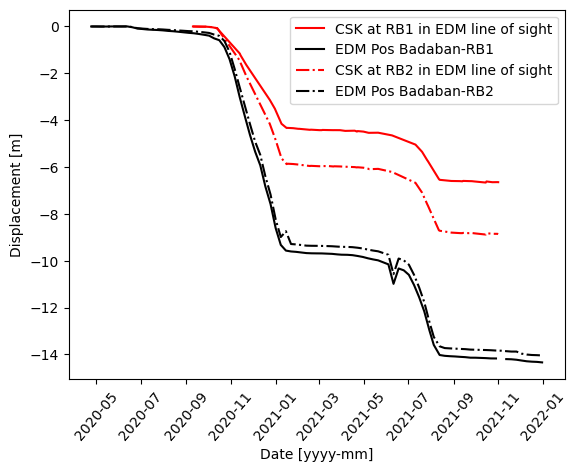

In [10]:
# compare results

fig, ax = plt.subplots(1,1)

ax.plot(unique_dates,-np.array(total_CSK_RB1),color='red', label='CSK at RB1 in EDM line of sight')
ax.plot(EDM_dates,np.mean(EDM_dist_min_max[:,0:2],axis=1)-np.mean(EDM_dist_min_max[:,0:2],axis=1)[0],color='black', label='EDM Pos Badaban-RB1')

ax.plot(unique_dates,-np.array(total_CSK_RB2),color='red',linestyle='-.', label='CSK at RB2 in EDM line of sight')
ax.plot(EDM_dates,np.mean(EDM_dist_min_max[:,2:4],axis=1)-np.mean(EDM_dist_min_max[:,2:4],axis=1)[0],color='black',linestyle='-.', label='EDM Pos Badaban-RB2')
# Rotating X-axis labels
for tick in ax.get_xticklabels():
    tick.set_rotation(50)
ax.set_xlabel('Date [yyyy-mm]')
ax.set_ylabel('Displacement [m]')
ax.legend()



In [11]:
%matplotlib osx
# plt.close('all')
# why is SPOT displacement so different for the two EDM locations
q_date = 55
CSK_mag = np.hypot(TSX_TS.iloc[:,-2],TSX_TS.iloc[:,-1])
fig, ax = plt.subplots(1,1)

disp_mag_map = ax.scatter(TSX_TS['Longitude'],TSX_TS['Latitude'],s=5,c=CSK_mag, vmin=0, vmax=15 )
ax.set_aspect('equal')
cbar = plt.colorbar(disp_mag_map)
cbar.set_label('displacement magnitude')

ax.scatter(x= np.array(reflectors)[:,0],y=np.array(reflectors)[:,1],s=30,marker='v',color='red')
# ax.set_title(f'speed from {unique_dates[q_date1]} to {unique_dates[q_date2]}')

In [12]:

# lava flow files:
L1888_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1888_v2.shp'
L1948_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1948.shp'
L1956_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1956.shp'
L1992_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1992.shp'
L1997_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1997.shp'
L1998_FILE  = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/L1998.shp'
CRATER_FILE = '/Users/tz20896/Documents/PhD/projects/Merapi2021/merapi_maps/Merapi_crater.shp'

# Read the shapefile
L1888  = gpd.read_file(L1888_FILE)
L1948  = gpd.read_file(L1948_FILE)
L1956  = gpd.read_file(L1956_FILE)
L1992  = gpd.read_file(L1992_FILE)
L1997  = gpd.read_file(L1997_FILE)
L1998  = gpd.read_file(L1998_FILE)
CRATER = gpd.read_file(CRATER_FILE)

# Extract latitude and longitude into separate columns
coords_L1888   = np.array(list(L1888["geometry"][0].coords))
coords_L1956_1 = np.array(list(L1956["geometry"][0].coords))
coords_L1956_2 = np.array(list(L1956["geometry"][1].coords))
coords_L1948   = np.array(list(L1948["geometry"][0].coords))
coords_L1992   = np.array(list(L1992["geometry"][0].coords))
coords_L1997   = np.array(list(L1997["geometry"][0].coords))
coords_L1998   = np.array(list(L1998["geometry"][0].coords))
coords_CRATER  = np.array(list(CRATER["geometry"][0].coords))


In [13]:
%matplotlib osx
# plt.close('all')
# why is SPOT displacement so different for the two EDM locations
q_date = 55
CSK_mag = np.hypot(CSK_TS.iloc[:,-2],CSK_TS.iloc[:,-1])
fig, ax = plt.subplots(1,1)

disp_mag_map = ax.scatter(CSK_TS['Longitude'],CSK_TS['Latitude'],s=10,c=CSK_mag, vmin=0, vmax=15 )
ax.set_aspect('equal')
cbar = plt.colorbar(disp_mag_map)
cbar.set_label('displacement magnitude')

ax.scatter(x= np.array(reflectors)[:,0],y=np.array(reflectors)[:,1],s=30,marker='v',color='red')
# ax.set_title(f'speed from {unique_dates[q_date1]} to {unique_dates[q_date2]}')

ax.plot(coords_L1888[:,0],coords_L1888[:,1],linewidth=2,color='tab:blue',label='L1888')
ax.plot(coords_L1948[:,0],coords_L1948[:,1],linewidth=2,color='tab:cyan',label='L1948')
ax.plot(coords_L1956_1[:,0],coords_L1956_1[:,1],linewidth=2,color='tab:red',label='L1956')
ax.plot(coords_L1956_2[:,0],coords_L1956_2[:,1],linewidth=2,color='tab:red')
ax.plot(coords_L1992[:,0],coords_L1992[:,1],linewidth=2,color='tab:purple',label='L1992')
ax.plot(coords_L1997[:,0],coords_L1997[:,1],linewidth=2,color='tab:olive',label='L1997')
ax.plot(coords_L1998[:,0],coords_L1998[:,1],linewidth=2,color='tab:green',label='L1998')
ax.plot(coords_CRATER[:,0],coords_CRATER[:,1],linewidth=2,color='black',linestyle='--',label='Crater rim')